In [1]:
using Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import Plots
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
using LaTeXStrings

In [3]:
include("utils.jl")
include("system.jl")
include("objectives.jl")
include("constraints.jl")

FinalYZGreatCircleConstraint (generic function with 1 method)

In [4]:
QC.QuantumDynamics()

LoadError: MethodError: no method matching QuantumCollocation.Dynamics.QuantumDynamics()

[0mClosest candidates are:
[0m  QuantumCollocation.Dynamics.QuantumDynamics([91m::Function[39m, [91m::NamedTrajectories.StructNamedTrajectory.NamedTrajectory[39m; verbose)
[0m[90m   @[39m [35mQuantumCollocation[39m [90m/local/lmseifert/Other/QuantumCollocation.jl/src/[39m[90m[4mdynamics.jl:260[24m[39m
[0m  QuantumCollocation.Dynamics.QuantumDynamics([91m::QuantumCollocation.Integrators.AbstractIntegrator[39m, [91m::NamedTrajectories.StructNamedTrajectory.NamedTrajectory[39m; kwargs...)
[0m[90m   @[39m [35mQuantumCollocation[39m [90m/local/lmseifert/Other/QuantumCollocation.jl/src/[39m[90m[4mdynamics.jl:257[24m[39m
[0m  QuantumCollocation.Dynamics.QuantumDynamics([91m::Vector{<:QuantumCollocation.Integrators.AbstractIntegrator}[39m, [91m::NamedTrajectories.StructNamedTrajectory.NamedTrajectory[39m; cuts, verbose)
[0m[90m   @[39m [35mQuantumCollocation[39m [90m/local/lmseifert/Other/QuantumCollocation.jl/src/[39m[90m[4mdynamics.jl:35[24m[39m
[0m  ...


In [5]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(
    V, 
    trunc; 
    acc=0.0, 
    bloch_basis=true,
    bloch_transformation_trunc=2*trunc,
    include_acc_derivative=true, 
    sparse=false)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
B = system.params[:bloch_states][:,1:trunc]
if system.params[:accelerated]
    B2 = blockdiagonal(B, B)
end

46×22 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 506 stored entries:
⎡⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎤
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⠿⠿⠿⠿⠿⢇⣀⣀⣀⣀⣀⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎣⠀⠀⠀⠀⠀⠘⠛⠛⠛⠛⠛⎦

In [6]:
system.H_drift_real

22×22 Matrix{Float64}:
  1.16045      -3.81709e-15  -1.95634      …   0.0           0.0
 -3.81714e-15   4.48243       2.87773e-15      0.0           0.0
 -1.95634       2.87756e-15   3.41669          0.0           0.0
 -6.00755e-13   2.38146       2.17156e-12      0.0           0.0
  0.699748      3.00751e-12  -2.52663          0.0           0.0
  8.57346e-11  -0.192284     -4.23322e-10  …   0.0           0.0
  0.0465362     3.54247e-10  -0.229777         0.0           0.0
  1.76779e-8    0.00533246   -9.66794e-8       0.0           0.0
  0.0012026    -7.83853e-8   -0.00657698       0.0           0.0
  1.67673e-6    7.34672e-5   -9.59911e-6       0.0           0.0
  1.60421e-5   -7.67887e-6   -9.1839e-5    …   0.0           0.0
  0.0           0.0           0.0              1.67673e-6    1.60421e-5
  0.0           0.0           0.0              7.34672e-5   -7.67887e-6
  0.0           0.0           0.0             -9.59911e-6   -9.1839e-5
  0.0           0.0           0.0              

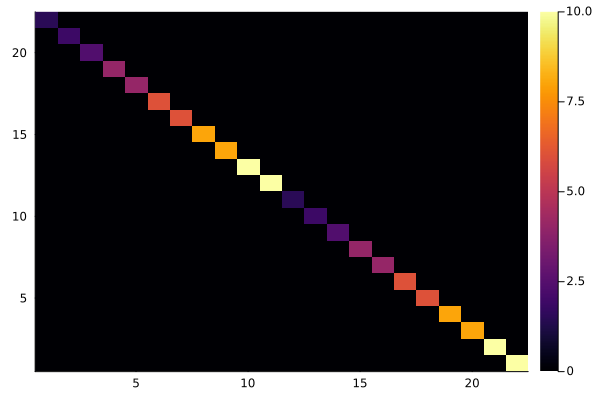

In [7]:
Plots.heatmap(abs.((system.H_drift_real+system.H_drives_real[1])[end:-1:1,:]).^(0.5))

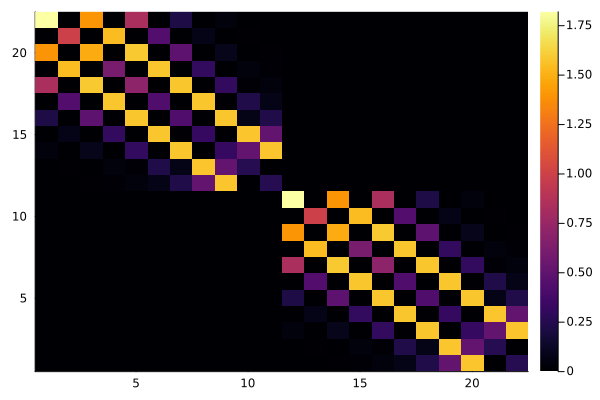

In [8]:
Plots.heatmap(abs.(system.H_drives_real[1][end:-1:1,:]).^(0.5))

In [9]:
duration = 2pi * 0.5 # in units of 1/E_R

T = 500
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts;

In [10]:
phi_bound = [1.0*pi]

#a = vcat(ones(T)', zeros(T)') 
#a = vcat(cos.(2pi * times/duration)', sin.(2pi * times/duration)')
#a = vcat(cos.(1. .+ 0.5*cos.(2π* 12. *times))', sin.(1. .+ 0.5*cos.(2π* 12. *times))')

# phi = 0.5 * (cos.(2pi * 4. * times) + cos.(2pi * 12. * times))
phi = rand(1, T)
#phi = zeros(1, T)
a = vcat(cos.(phi), sin.(phi))
acc = collect(times')

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×500 Matrix{Float64}:
 8732.07  -3038.65  13029.5  -20610.8  …  -5492.08  291.428  987.509  0.0

Z_split = NT.load_traj("interferometer/split_victor.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor.jld2")

Z_split = NT.load_traj("interferometer/split_victor_opt2.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor2_opt2.jld2")

a, dts = get_interferometer(Z_split, Z_mirror, [])

Z = NT.load_traj("./end2end/traj.jld2")

phi, dts_old = Z.phi, vec(Z.dts)

duration = sum(dts_old) - dts_old[1] # in units of 1/E_R
T = 1001
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts

phi = interpolate_controls(phi, dts_old, dts)

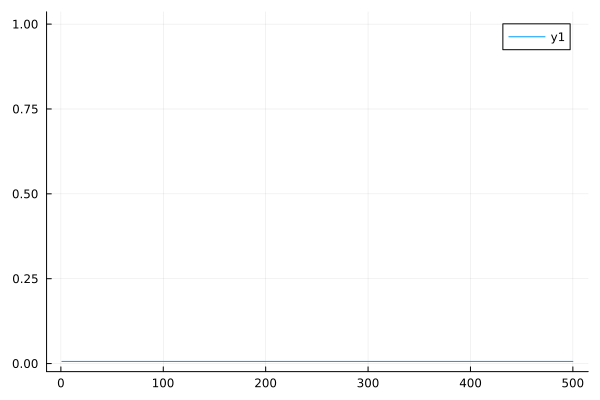

In [11]:
Plots.plot(dts)

In [12]:
duration = sum(dts) - dts[1] # in units of 1/E_R

T = length(dts)
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts;

In [13]:
times

500-element Vector{Float64}:
 0.0
 0.006295776860901389
 0.012591553721802779
 0.018887330582704167
 0.025183107443605558
 0.031478884304506946
 0.037774661165408334
 0.04407043802630972
 0.05036621488721111
 0.056661991748112504
 0.06295776860901389
 0.06925354546991529
 0.07554932233081668
 ⋮
 3.072339108119884
 3.0786348849807856
 3.084930661841687
 3.0912264387025883
 3.09752221556349
 3.1038179924243914
 3.1101137692852925
 3.116409546146194
 3.1227053230070956
 3.129001099867997
 3.1352968767288987
 3.1415926535897998

In [14]:
phi_bound = [1.0 * pi]

a = vcat(cos.(phi), sin.(phi))
acc = collect(times')

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×500 Matrix{Float64}:
 8732.07  -3038.65  13029.5  -20610.8  …  -5492.08  291.428  987.509  0.0

In [15]:
acc

1×500 Matrix{Float64}:
 0.0  0.00629578  0.0125916  0.0188873  …  3.12271  3.129  3.1353  3.14159

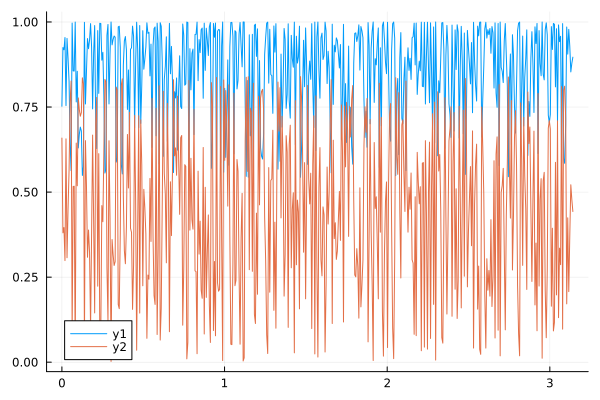

In [16]:
Plots.plot(times, a')

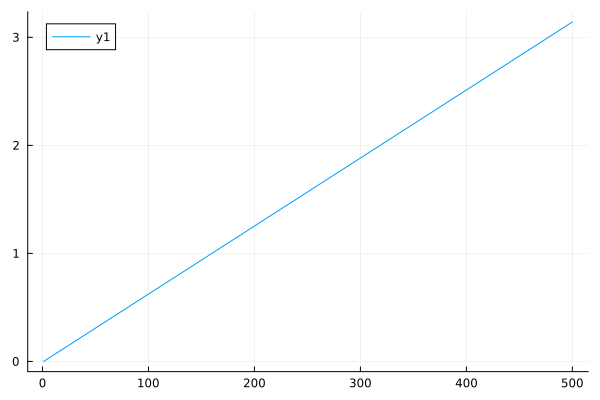

In [17]:
Plots.plot(times)

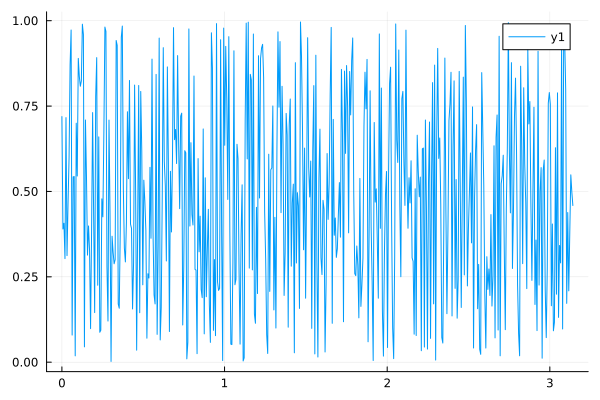

In [18]:
Plots.plot(times, phi')

In [19]:
# psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(0, dim)
if system.params[:accelerated]
    append!(psi0, zeros(dim))
end

22-element Vector{ComplexF64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

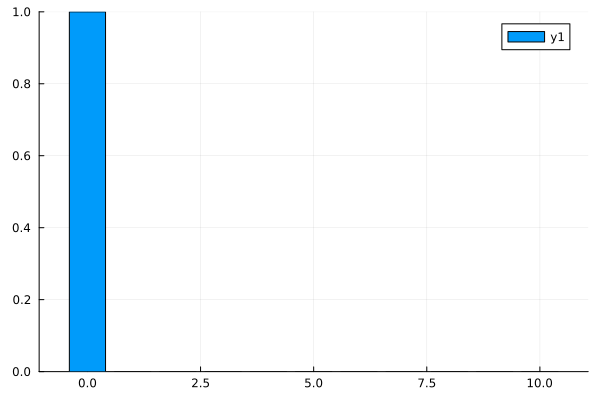

In [20]:
Plots.bar(0:dim-1, abs2.(psi0[1:dim]))

In [21]:
psi0_iso = QC.ket_to_iso(psi0)

44-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [22]:
time_flight = 2pi * 0.001
T_flight = Int(round(time_flight/2pi*2000; digits=0))

2

In [23]:
#jumps = [(Z_split.T, time_flight), (Z_split.T+Z_mirror.T, time_flight)]
#jumps = [(div(T, 3), time_flight), (2*div(T, 3), time_flight)]
jumps = [(div(T, 2), time_flight)]
#jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, T_flight)

1-element Vector{Matrix{Float64}}:
 [0.9999084954304516 1.4286307193915204e-20 … -0.0 -0.0; 1.112133997582206e-20 0.9997592430858332 … -0.0 -0.0; … ; 9.101946054272243e-9 4.5934467033425304e-9 … 0.808900376767226 -3.447960311313274e-16; -9.513451366960641e-10 4.394756695988669e-8 … -3.5071733966741387e-16 0.8089003767672237]

In [24]:
jumps

1-element Vector{Tuple{Int64, Float64}}:
 (250, 0.006283185307179587)

jumps = [(100, time_flight), (200, time_flight)]
#jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, 10000)

In [25]:
G

1-element Vector{Matrix{Float64}}:
 [0.9999084954304516 1.4286307193915204e-20 … -0.0 -0.0; 1.112133997582206e-20 0.9997592430858332 … -0.0 -0.0; … ; 9.101946054272243e-9 4.5934467033425304e-9 … 0.808900376767226 -3.447960311313274e-16; -9.513451366960641e-10 4.394756695988669e-8 … -3.5071733966741387e-16 0.8089003767672237]

In [26]:
U = [QC.iso_vec_to_operator(QC.iso_operator_to_iso_vec(g)) for g in G]

1-element Vector{Matrix{ComplexF64}}:
 [0.9999084954304516 + 0.013527777570998984im 1.4286307193915204e-20 + 3.3951466884939204e-18im … 0.0 + 0.0im 0.0 + 0.0im; 1.112133997582206e-20 + 2.6429909477663835e-18im 0.9997592430858332 - 0.02194210255289795im … 0.0 + 0.0im 0.0 + 0.0im; … ; 2.8904774233199306e-9 + 9.101946054272243e-9im 1.5489300581210501e-9 + 4.5934467033425304e-9im … 0.808900376767226 - 0.5879457291841144im -3.447960311313274e-16 - 4.743731022198393e-16im; -3.0211579183269247e-10 - 9.513451366960641e-10im 1.4819309299038349e-8 + 4.394756695988669e-8im … -3.5071733966741387e-16 - 4.825196852598114e-16im 0.8089003767672237 - 0.5879457291841172im]

Plots.heatmap(sqrt.(abs.(U[1])), yflip=true)

Plots.heatmap(sqrt.(abs.(U[2])), yflip=true)

In [27]:
psi_iso = shaken_lattice_rollout(psi0_iso, a, dts, system, jumps, G)

44×500 Matrix{Float64}:
 1.0   0.999876      0.999576      0.999071     …   0.938924      0.9401
 0.0  -0.0125782    -0.019831     -0.0273713        0.2635        0.258437
 0.0   3.92789e-6    6.17504e-5    0.000112999      0.0241505     0.0235583
 0.0  -0.00292704   -0.00458204   -0.00625592      -0.0477822    -0.0509686
 0.0   3.60463e-6   -3.40091e-5   -5.69505e-5      -0.0150149    -0.0202189
 0.0   0.000190078   0.000285537   0.000366239  …  -0.00333485   -0.00345163
 0.0   9.44105e-6    1.79176e-5    3.40732e-5       0.00114572    0.000998599
 0.0  -4.66756e-6   -5.96517e-6   -5.74303e-6      -4.3829e-5    -2.28308e-5
 0.0   1.0393e-6     2.1339e-6     3.37093e-6      -0.000209653  -0.000276353
 0.0  -5.02819e-8   -2.86354e-8    3.54392e-8       1.97689e-5    9.7373e-6
 0.0   4.11675e-8    5.98111e-8    3.41877e-8   …  -3.16552e-6   -5.81443e-6
 0.0   0.0          -2.04142e-8   -1.18633e-7      -0.806098     -0.802249
 0.0   0.0           4.20895e-7    1.55111e-6       1.97793   

In [28]:
psi_iso += rand(size(psi_iso)...)

44×500 Matrix{Float64}:
 1.82927   1.8964     1.6767     …   1.57017     1.0664      0.948596
 0.960075  0.258502   0.410174       0.502786    0.931493    0.44023
 0.267775  0.360553   0.21504        0.366888    0.0806722   0.940497
 0.154817  0.742231   0.0901527      0.212462    0.122158    0.757009
 0.98988   0.117871   0.811503       0.763094    0.851617    0.899877
 0.93446   0.649012   0.764051   …   0.914115    0.358538    0.960656
 0.752216  0.712297   0.0872151      0.206708    0.979758    0.48642
 0.010861  0.156783   0.523131       0.0545155   0.28704     0.86568
 0.421348  0.26518    0.0818844      0.414471    0.671329    0.227394
 0.430048  0.658272   0.85703        0.0637702   0.675302    0.140238
 0.823059  0.0663984  0.642327   …   0.907713    0.167236    0.849521
 0.653171  0.317338   0.0735223     -0.267571   -0.220036   -0.227166
 0.526338  0.915875   0.336659       2.20711     2.77016     2.19413
 ⋮                               ⋱                          
 0.466677

psi_iso = QC.rollout(psi0_iso, a, dts, system)#; integrator=exp)

In [29]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

22×500 Matrix{Float64}:
 3.39697    3.62435   3.53101    …  3.57685      2.1608       0.939776
 1.44479    0.575205  0.297305      1.23347      1.12342      0.274026
 0.399009   0.409136  0.0672111     0.134837     0.00990552   0.94914
 0.235551   0.921258  0.0182316     0.164298     0.0914013    1.17364
 1.20885    0.662846  1.58034       1.05286      0.935262     1.25144
 1.04426    0.910391  1.06298    …  0.892271     0.262786     1.65947
 0.625253   0.596045  0.176983      0.0600277    1.69678      0.263651
 0.396408   0.190147  0.361131      0.662824     0.0898519    0.751205
 0.183902   0.646087  0.661367      0.991666     0.536162     0.145055
 1.14338    1.38072   1.21215       0.00421245   1.13805      0.623412
 0.895215   0.673985  0.859444   …  0.897066     0.706652     0.8917
 1.0454     1.00295   0.172191      2.04809      1.74745      1.44782
 0.424584   1.08031   0.119157      9.49649     12.5163      10.2305
 0.64691    0.948746  0.0369888     5.14137      3.7024       

In [30]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xlims!(p, (times[1], times[end]))
    rel_y = 0.98
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end]
        Plots.vline!(p, [times[cut]], color=:red, label=nothing)
        Plots.annotate!(((rel_x, rel_y), (string(round(jump_time; digits=1)), 10, :red)))
    end
    Plots.xlabel!(p, L"t \, [1/\omega_R]")
    return p
end

format_plot (generic function with 4 methods)

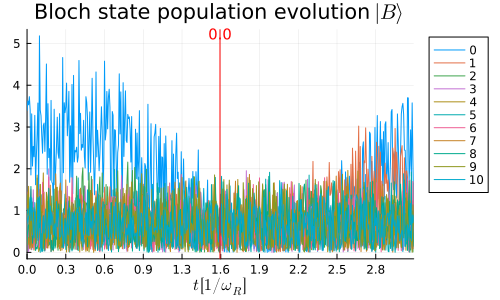

In [31]:
p = Plots.plot(times, pops[1:dim,:]', labels=(0:dim-1)', legend=:outertopright, size=(500,300))
Plots.plot!(
    p,
    title=L"Bloch state population evolution $|B\rangle$"
)
format_plot(p)

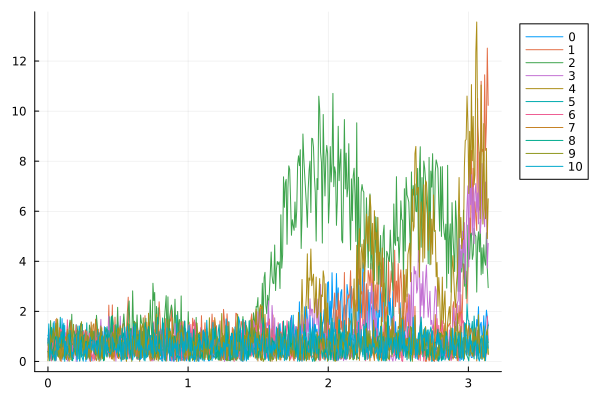

In [32]:
Plots.plot(times, pops[dim+1:end,:]', labels=(0:dim-1)', legend=:outertopright)

In [33]:
comps = (
    psi_iso = psi_iso,
    phi = phi,
    a = a,
    acc = acc,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    phi = [0.],
    #da = da0
)
final = (;
    phi = [0.],
    #da = zeros(2)
)
goal = (;)
bounds = (
    # phi = phi_bound,
    dts = dt_bound,
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.829269436393884 1.8963977342626472 … 1.0664044360863631 0.9485956599364893; 0.9600748402556588 0.25850230956153003 … 0.931493361511789 0.4402299126590656; … ; 0.0 0.006295776860901389 … 3.1352968767288987 3.1415926535897998; 0.006295776860901389 0.006295776860901389 … 0.006295776860901389 0.006295776860901389], [1.829269436393884, 0.9600748402556588, 0.26777524140267583, 0.15481695976944265, 0.9898799399553304, 0.9344604044151246, 0.7522160662068414, 0.010860968160860685, 0.4213479846403282, 0.43004790250087666  …  0.8489447579891563, 0.5057002783455461, 0.948542697260168, 0.5292654980106148, 0.2947699238451351, 0.4587762544155989, 0.8965951059824456, 0.4428512345340443, 3.1415926535897998, 0.006295776860901389], 500, :dts, 49, (psi_iso = 44, phi = 1, a = 2, acc = 1, dts = 1, states = 48, controls = 1), (dts = ([0.006295776860901389], [0.006295776860901389]),), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

Z_guess = copy(Z)

Z_guess = trajectory_shrink_extend(NT.load_traj("end2end/growing_trajectory/101.jld2"), 111)

Z_guess = NT.load_traj("end2end/growing_trajectory/101.jld2")

T = Z_guess.T
duration = 2pi*(T-1)/1000
psi_iso = Z_guess.psi_iso
phi = Z_guess.phi
a = Z_guess.a
dts = vec(Z_guess.dts)
full_times = get_times(dts, jumps)
times = full_times

pops_goal = abs2.(get_bloch_state(system; lvl=0))

dim = system.params[:dim]
J = NameComponentPathObjective(
    :psi_iso,
    1:dim,
    [T],
    [time -> pop for pop in pops_goal],
    [x -> abs2.(x) for _=1:dim],
    fill(1., dim, 1);
    is_iso=true
)

MZFI = (8pi*(duration/2)^2)^2

In [34]:
MZFI = (8pi*(full_times[end]/2)^2)^2

3845.4951224590905

In [35]:
function Fisher(psi, dpsi)
    psi = B*psi
    dpsi = B*dpsi
    eps = 0.0
    P = abs2.(psi)
    D = 2*real.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F
end 


Fisher (generic function with 1 method)

In [36]:
function QFI(psi, dpsi)
    return 4*(real(dpsi'*dpsi) - abs2(dpsi'*psi))
end

QFI (generic function with 1 method)

In [37]:
fisher_loss = psi_dpsi -> -Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim]) / MZFI

#370 (generic function with 1 method)

In [38]:
qfi_loss = psidpsi -> -QFI(psidpsi[1:dim], psidpsi[dim+1:end])

#372 (generic function with 1 method)

In [39]:
log_sensitivity_loss = psi_dpsi -> -0.5 * log10(Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])) + 0.5 * log10(MZFI)

#374 (generic function with 1 method)

In [40]:
log_qfi_sensitivity_loss = psi_dpsi -> -0.5 * log10(QFI(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])) + 0.5 * log10(MZFI)

#376 (generic function with 1 method)

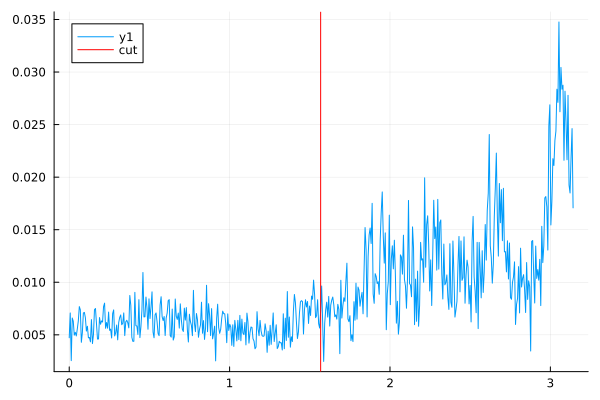

In [41]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso[:,t])) for t=1:T];
p = Plots.plot(times, fisher_evol)
Plots.vline!(p, times[cuts], color=:red, label="cut")

flight_times = 2pi * collect(1:40)

#fishers = []
for flight_time in flight_times
    println(flight_time)
    jumps = [(211, flight_time), (632, flight_time)]
    cuts = [jump[1] for jump in jumps]
    full_times = get_times(dts, jumps)
    G = get_shaken_lattice_propagator(system, times, jumps, 10000)
    psi_iso = shaken_lattice_rollout(psi0_iso, a, dts, system, jumps, G)
    push!(fishers, fisher_loss(psi_iso[:,end]))
end

In [42]:
Plots.plot(flight_times, hcat(-fishers, (4pi)^2 * flight_times.^4))

LoadError: UndefVarError: `flight_times` not defined

In [46]:
kernel = sinc_kernel(50., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

500×500 Matrix{Float64}:
  0.854618     -0.138052     -0.126402     …  -0.000943619  -0.00128135
 -0.138052      0.864331     -0.128816        -0.000550694  -0.000943619
 -0.126402     -0.128816      0.873112        -0.000120651  -0.000531191
 -0.111146     -0.117931     -0.120761         0.000305795  -8.34853e-5
 -0.0931956    -0.103682     -0.110833         0.00068862    0.000357033
 -0.0735929    -0.0869215    -0.0977159    …   0.00099233    0.000748942
 -0.0534412    -0.0686265    -0.0821993        0.00118934    0.00105583
 -0.0338272    -0.0498272    -0.0651903        0.00126256    0.00124978
 -0.0157497    -0.0315383    -0.0476509        0.001207      0.00131398
 -5.50858e-5   -0.0146914    -0.0305321        0.00103015    0.00124429
  0.0126132    -7.48359e-5   -0.0147102    …   0.000751165   0.00104959
  0.0218495     0.0117132    -0.000930649      0.000398952   0.000750761
  0.0275013     0.020297      0.010237         9.27476e-6    0.000378664
  ⋮                              

In [47]:
#J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(vcat(get_bloch_state(system; lvl=0), zeros(dim))), loss=:InfidelityLoss, Q=1e2)
#J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(get_bloch_state(system; lvl=3)), loss=:InfidelityLoss, Q=1e2)

# J += NameComponentObjective(
#     :psi_iso,
#     [1:2*dim...],
#     [1:T...],
#     fisher_loss,
#     ([1:T...] ./ T).^2;
#     is_iso=true
# )

J1 = NameComponentObjective(
    :psi_iso,
    [1:2*dim...],
    [T],
    log_sensitivity_loss;
    is_iso=true
)

# convolution
J2 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

# encourage higher Bloch states
R = - [
    0., #0
    1., #1
    2., #2
    3., #3
    3., #4
    25., #5
    25., #6
    70., #7
    70., #8
    9., #9
    9., #10
] / T / 10.
J3 = NameComponentQuadraticRegularizer(:psi_iso, 1:dim, Z_guess, R; is_iso=true)

J = J1 + J2 #+ J3

QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(var"#L#123"{Symbol, Vector{Int64}, Vector{Float64}, var"#get_comp_idc_traj#122"{Bool, Vector{Int64}}}(:psi_iso, [500], [1.0], var"#get_comp_idc_traj#122"{Bool, Vector{Int64}}(true, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  13, 14, 15, 16, 17, 18, 19, 20, 21, 22]), Core.Box(var"#112#119"{var"#374#375"}(var"#374#375"()))), var"#∇L#124"{Symbol, Vector{Int64}, Vector{Float64}, var"#get_comp_idc_traj#122"{Bool, Vector{Int64}}, var"#113#120"}(:psi_iso, [500], [1.0], var"#get_comp_idc_traj#122"{Bool, Vector{Int64}}(true, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  13, 14, 15, 16, 17, 18, 19, 20, 21, 22]), var"#113#120"(Core.Box(var"#112#119"{var"#374#375"}(var"#374#375"())))), var"#∂²L#128"{var"#∂²L#117#129"{Symbol, Vector{Int64}, Vector{Float64}, var"#∂²L_structure#125"{Symbol, Vector{Int64}, var"#get_comp_id

In [48]:
J.L(Z_guess.datavec, Z_guess)

2.7681887994723886

In [49]:
J1.L(Z_guess.datavec, Z_guess)

0.8837506665912824

In [50]:
J2.L(Z_guess.datavec, Z_guess)

1.8844381328811062

In [51]:
J3.L(Z_guess.datavec, Z_guess)

-7.168235123016606

In [52]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        (:a, :acc),
        :dts;
        order=4
    )
]

1-element Vector{QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}}:
 QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [1.1604477548756553 -3.817086743338521e-15 … 0.0 0.0; -3.817137565483579e-15 4.482431989861648 … 0.0 0.0; … ; 0.0 0.0 … 99.96841438887265 -4.762232631809572e-13; 0.0 0.0 … -4.746265189765724e-13 99.96841438886783], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.3135260969173914 3.2766992507114728e-15 … 0.0 0.0; 3.3964667131343313e-15 -0.9899576231226913 … 0.0 0.0; … ; 0.0 0.0 … 0.06315791627452493 5.695583959816801e-13; 0.0 0.0 … 5.695645302001018e-13 0.06315791627991879], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -9.864038186824139e-7 -4.997744272231374e-7 … 0.0 0.0; 1.0309998214957898e-7 -4.781566332150105e-6 … 0.0 0.0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 

In [53]:
dynamics = QC.QuantumDynamics(
    integrators,
    Z_guess;
    cuts=cuts
)

QuantumCollocation.Dynamics.QuantumDynamics(QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}[QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [1.1604477548756553 -3.817086743338521e-15 … 0.0 0.0; -3.817137565483579e-15 4.482431989861648 … 0.0 0.0; … ; 0.0 0.0 … 99.96841438887265 -4.762232631809572e-13; 0.0 0.0 … -4.746265189765724e-13 99.96841438886783], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.3135260969173914 3.2766992507114728e-15 … 0.0 0.0; 3.3964667131343313e-15 -0.9899576231226913 … 0.0 0.0; … ; 0.0 0.0 … 0.06315791627452493 5.695583959816801e-13; 0.0 0.0 … 5.695645302001018e-13 0.06315791627991879], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -9.864038186824139e-7 -4.997744272231374e-7 … 0.0 0.0; 1.0309998214957898e-7 -4.781566332150105e-6 … 0.0 0.0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0

In [54]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    vcat([get_link_constraints(
        :psi_iso, 
        Z_guess, 
        c, 
        g, 
        (; phi=[0.]), 
        (; phi=[0.]); 
        hard_equality_constraint=true)
        for (c, g) in zip(cuts, G)]...)...,
    TimeAffineLinearControlConstraint(:acc, 1, Z_guess; jumps=jumps),
    custom_bounds_constraint(:phi, Z_guess, vcat(cuts, cuts .+ 1), phi_bound)
    # NameComponentPathConstraint(
    #     :a,
    #     [3],
    #     Z_guess,
    #     [t -> t],
    #     [x -> x]
    # )
]

6-element Vector{QuantumCollocation.Constraints.AbstractConstraint}:
 QuantumCollocation.Constraints.NonlinearEqualityConstraint(var"#g#343"{var"#gQ#338", var"#gI#337", Vector{Int64}, Vector{Int64}, Vector{Int64}, Int64}(var"#gQ#338"(), var"#gI#337"(), [45, 94, 143, 192, 241, 290, 339, 388, 437, 486  …  24055, 24104, 24153, 24202, 24251, 24300, 24349, 24398, 24447, 24496], [47, 96, 145, 194, 243, 292, 341, 390, 439, 488  …  24057, 24106, 24155, 24204, 24253, 24302, 24351, 24400, 24449, 24498], [46, 95, 144, 193, 242, 291, 340, 389, 438, 487  …  24056, 24105, 24154, 24203, 24252, 24301, 24350, 24399, 24448, 24497], 500), var"#∂g#350"{var"#∂gQ#340", var"#∂gI#339", Vector{Int64}, Int64}(var"#∂gQ#340"(), var"#∂gI#339"(), [45, 94, 143, 192, 241, 290, 339, 388, 437, 486  …  24055, 24104, 24153, 24202, 24251, 24300, 24349, 24398, 24447, 24496], 500), [(1, 46), (1, 45), (2, 95), (2, 94), (3, 144), (3, 143), (4, 193), (4, 192), (5, 242), (5, 241)  …  (996, 24302), (996, 24300), (997, 24351), (9

In [55]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

QuantumCollocation.IpoptOptions.Options{Float64}(1.0e-8, 100.0, 200, 1.0e6, 1.0, 1.0e-12, 0.001, 1.0e-6, 15, 1.0e10, 0.01, 0.01, 1.0e-5, 1.0e8, 0.0001, 5, nothing, "no", "no", "no", "text", "no", "no", "original", 1, 0.0, "no", nothing, "mumps", 10, 3)

In [56]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    dynamics;
    constraints=constraints,
    options=options,
)

applying constraint: initial value of psi_iso
applying constraint: initial value of phi
applying constraint: final value of phi
applying constraint: bounds on dts
applying constraint: linear vector link constraint
applying constraint: fix :phi before cut at t=250
applying constraint: fix :phi after cut at t=250
applying constraint: time affine linear control constraint
applying constraint: bounds on phi


QuantumCollocation.Problems.QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(50) … MOI.VariableIndex(24403) MOI.VariableIndex(24452); MOI.VariableIndex(2) MOI.VariableIndex(51) … MOI.VariableIndex(24404) MOI.VariableIndex(24453); … ; MOI.VariableIndex(48) MOI.VariableIndex(97) … MOI.VariableIndex(24450) MOI.VariableIndex(24499); MOI.VariableIndex(49) MOI.VariableIndex(98) … MOI.VariableIndex(24451) MOI.VariableIndex(24500)], QuantumCollocation.QuantumSystems.QuantumSystem{Float64}([1.1604477548756553 -3.817086743338521e-15 … 0.0 0.0; -3.817137565483579e-15 4.482431989861648 … 0.0 0.0; … ; 0.0 0.0 … 99.96841438887265 -4.762232631809572e-13; 0.0 0.0 … -4.746265189765724e-13 99.96841438886783], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.3135260969173914 3.2766992507114728e-15 … 0.0 0.0; 3.3964667131343313e-15 -0.9899576231226913 … 0.0 0.0; … ; 0.0 0.0 … 0.06315791627452493 5.69558395981

In [57]:
QC.solve!(prob)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:  1503508
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   234192

Total number of variables............................:    23952
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:    23456
Total number of inequality c

In [58]:
Z_guess = NT.copy(Z)

LoadError: UndefVarError: `Z` not defined

In [59]:
Z = prob.trajectory

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 0.9999081283168132 … 0.6902617219379563 0.689576348951236; 0.0 1.1165942347424167e-20 … 0.19368791819481299 0.1837303474162827; … ; -3.789038160474437e-29 0.006295776860901389 … 3.1352842851751914 3.141580062036093; 0.006295776860901389 0.006295776860901389 … 0.006295776860901389 0.006295776860901389], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  5.303058115830967, -1.7075261530105181, -2.2550667475927026, -0.960537757722437, -0.5970870955717722, 0.0, 1.0, 0.0, 3.141580062036093, 0.006295776860901389], 500, :dts, 49, (psi_iso = 44, phi = 1, a = 2, acc = 1, dts = 1, states = 48, controls = 1), (dts = ([0.006295776860901389], [0.006295776860901389]),), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0]), (phi = [0.0],), NamedTuple(), (psi_iso = 1:44, phi = 45:45, a = 46:47, acc = 48:48, dts = 49:49, states = [1, 2, 3, 4, 5, 6, 7, 8, 9

In [60]:
J1.L(Z.datavec, Z)

-0.07358826354414139

In [61]:
J2.L(Z.datavec, Z)

0.000713584978173806

In [62]:
J3.L(Z.datavec, Z)

-0.13897521600584214

In [63]:
Z.psi_iso

44×500 Matrix{Float64}:
 1.0   0.999908      0.999634      0.999178     …   0.690262     0.689576
 0.0   1.11659e-20  -0.00210949   -0.00627661       0.193688     0.18373
 0.0  -3.04479e-19  -1.15703e-6   -1.07832e-5      -0.371542    -0.381806
 0.0   2.91968e-19  -0.000491483  -0.00145874      -0.155956    -0.147238
 0.0  -4.64101e-19   8.66679e-7    9.51931e-6      -0.239201    -0.245119
 0.0   1.09572e-19   3.21687e-5    9.42164e-5   …  -0.0329891   -0.0342777
 0.0  -4.18199e-20   3.94106e-7    3.76526e-6       0.00491788   0.00731024
 0.0   1.8058e-22   -8.17964e-7   -2.30307e-6      -0.0295476   -0.0369927
 0.0   8.39708e-21   3.7296e-8     3.31163e-7      -0.0329865   -0.0235497
 0.0  -4.27562e-22  -1.03939e-8   -2.61145e-8      -0.00463042  -0.00654369
 0.0   1.59652e-22   2.29396e-9    1.26058e-8   …   0.0019748   -0.00875664
 0.0  -4.79638e-28   5.10749e-10   2.38806e-9      -9.28546     -9.28191
 0.0  -2.54031e-27  -1.22891e-6   -4.15747e-6      15.6989      15.9593
 ⋮       

In [64]:
#psi_iso_rollout = QC.rollout(psi0_iso, vcat(Z.a, Z.acc'), dts, system; integrator=exp)
#psi_iso_rollout = Z.psi_iso
psi_iso_rollout = shaken_lattice_rollout(psi0_iso, Z.a, vec(Z.dts), system, jumps, G)#; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

22×500 Matrix{Float64}:
 1.0  1.0          0.999995     0.999958     …    0.482369       0.482773
 0.0  7.01355e-36  4.45015e-6   3.93987e-5        0.182258       0.181541
 0.0  7.81542e-34  5.68372e-9   1.38653e-7        0.236621       0.236636
 0.0  4.36588e-35  2.4172e-7    2.13447e-6        0.032347       0.0325763
 0.0  1.09804e-34  7.28639e-10  1.79122e-8        0.0618672      0.06191
 0.0  1.05605e-36  1.04281e-9   9.12646e-9   …    0.00115245     0.00117595
 0.0  1.53837e-37  3.50285e-12  1.03468e-10       0.00013123     0.000130976
 0.0  8.70085e-43  6.90287e-13  5.93997e-12       0.00149799     0.00150037
 0.0  1.88084e-39  4.29599e-15  2.26839e-13       0.00139369     0.00139693
 0.0  1.99439e-42  1.17485e-16  9.48601e-16       4.4894e-5      4.44178e-5
 0.0  2.74596e-43  7.63964e-18  2.95669e-16  …    0.000317408    0.000315415
 0.0  0.0          2.31934e-41  4.77838e-17     109.778        108.801
 0.0  0.0          1.78996e-8   1.61044e-7      355.843        358.031
 0.0  

In [65]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xlims!(p, (times[1], times[end]))
    rel_y = 0.98
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end]
        Plots.vline!(p, [times[cut]], color=:red, label=nothing)
        Plots.annotate!(((rel_x, rel_y), (string(round(jump_time; digits=1)), 10, :red)))
    end
    Plots.xlabel!(p, L"t \, [1/\omega_R]")
    return p
end

format_plot (generic function with 4 methods)

In [66]:
pops_p = abs2.(B2 * psi)
dim_p = div(size(pops_p, 1), 2)
p_max = div(dim_p, 2)

11

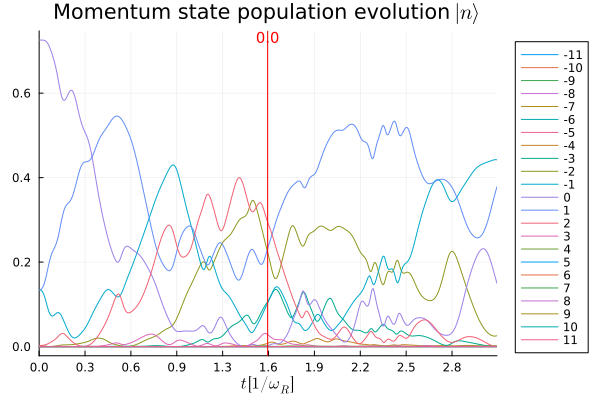

In [67]:
p = Plots.plot(times, pops_p[1:dim_p,:]', labels=(-p_max:p_max)', legend=:outertopright)
Plots.plot!(
    p,
    title=L"Momentum state population evolution $|n\rangle$"
)
format_plot(p)

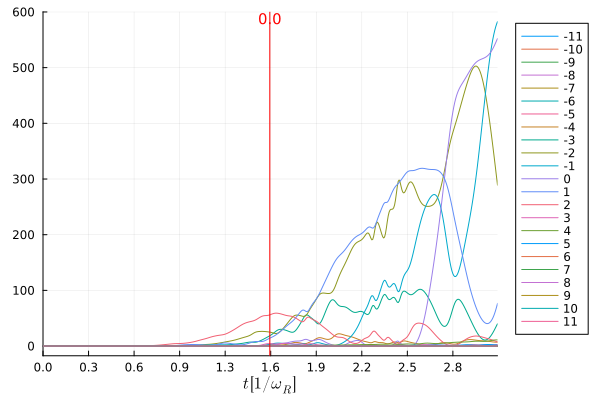

In [68]:
p = Plots.plot(times, pops_p[dim_p+1:end,:]', labels=(-p_max:p_max)', legend=:outertopright)
format_plot(p)

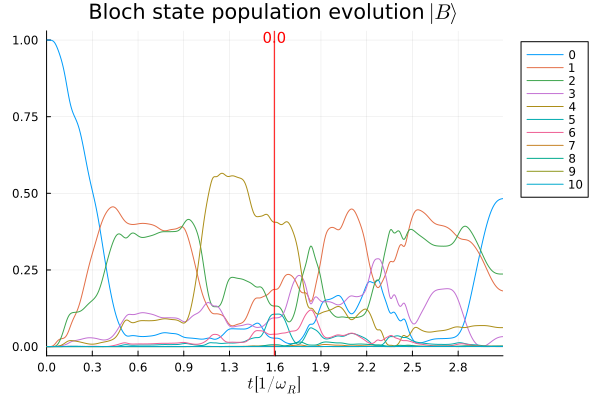

In [69]:
p = Plots.plot(times, pops[1:dim,:]', labels=(0:dim-1)', legend=:outertopright)
Plots.plot!(
    p,
    title=L"Bloch state population evolution $|B\rangle$"
)
format_plot(p)

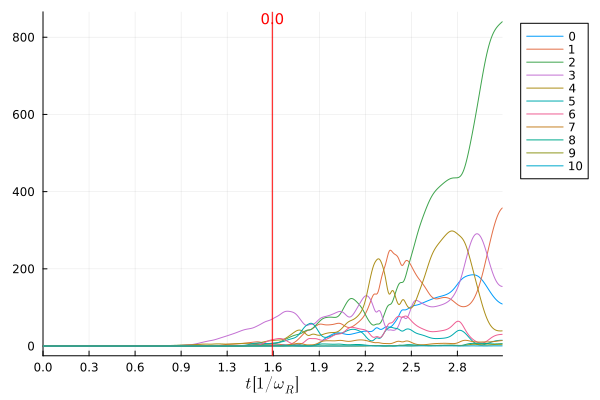

In [70]:
p = Plots.plot(times, pops[dim+1:end,:]', labels=(0:dim-1)', legend=:outertopright)
format_plot(p)

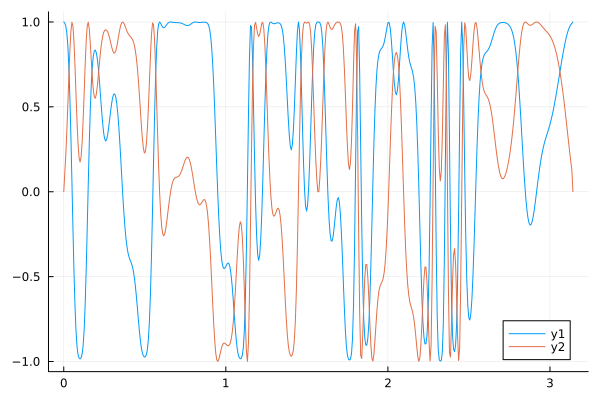

In [71]:
Plots.plot(times, Z.a')

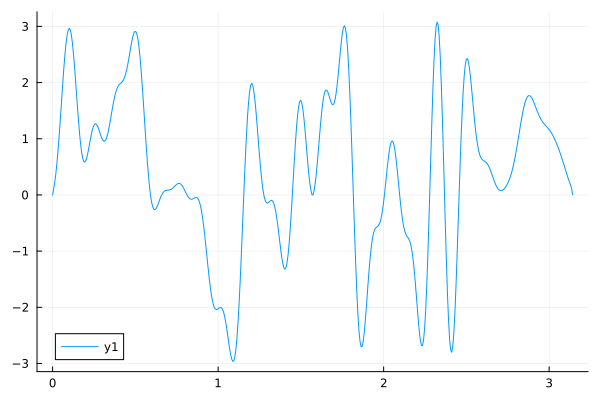

In [72]:
Plots.plot(times, Z.phi')

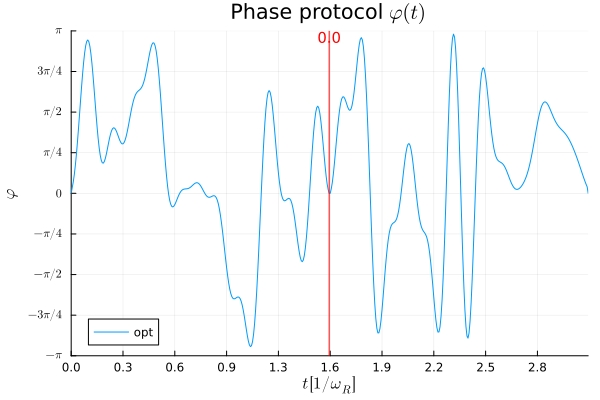

In [73]:
pi_ticks = LinRange(-pi, pi, 9)
pi_lbls = [L"-\pi", L"-3\pi/4", L"-\pi/2", L"-\pi/4", L"0", L"\pi/4", L"\pi/2", L"3\pi/4", L"\pi"]
p = Plots.plot(times, Z.phi', ylim=(-pi, pi), yticks=(pi_ticks, pi_lbls), label="opt")
# Plots.plot!(p, times, phi_guess, alpha=0.5, label="guess")
format_plot(p)
Plots.plot!(
    p,
    title=L"Phase protocol $\varphi(t)$",
    ylabel=L"\varphi"
)

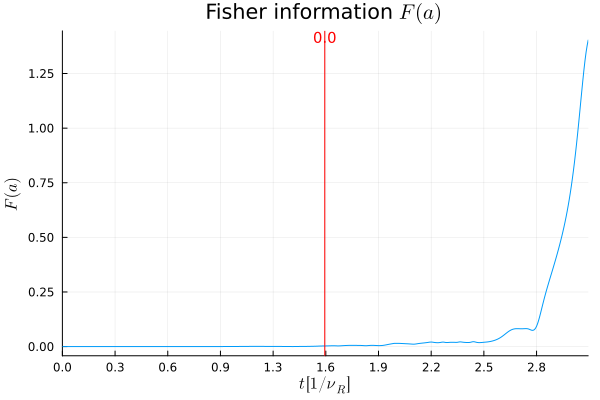

In [74]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso_rollout[:,t])) for t=1:T];
p = Plots.plot(times, fisher_evol, label=nothing)
format_plot(p)
Plots.plot!(
    p,
    title=L"Fisher information $F(a)$",
    xlabel=L"t \, [1/\nu_R]",
    ylabel=L"F(a)"
)

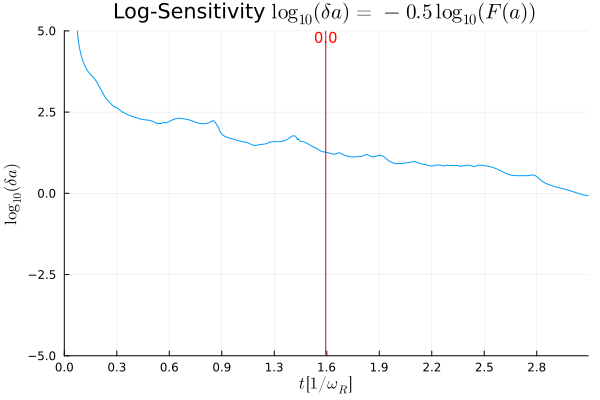

In [75]:
log_sensitivity_evol = [log_sensitivity_loss(QC.iso_to_ket(psi_iso_rollout[:,t])) for t=1:T]
p = Plots.plot(times[2:end], log_sensitivity_evol[2:end], ylim=(-5., 5.), label=nothing)
format_plot(p)
Plots.plot!(
    p,
    title=L"Log-Sensitivity $\log_{10}(\delta a) = -0.5 \, \log_{10}(F(a))$",
    ylabel=L"\log_{10}(\delta a)"
)

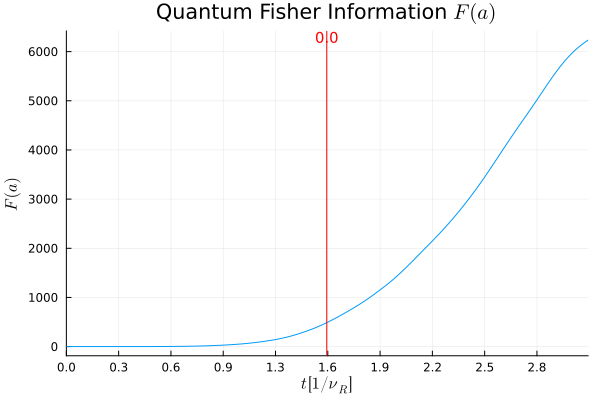

In [76]:
qfi_evol = [-qfi_loss(QC.iso_to_ket(psi_iso_rollout[:,t])) for t=1:T];
p = Plots.plot(times, qfi_evol, label=nothing)
format_plot(p)
Plots.plot!(
    p,
    title=L"Quantum Fisher Information $F(a)$",
    xlabel=L"t \, [1/\nu_R]",
    ylabel=L"F(a)"
)

In [79]:
F = fisher_evol[end]
F, 1/sqrt(F)

(1.403161610515753, 0.844201564950855)

In [80]:
#freqs = collect(12.464:0.001:12.468)
freqs = collect(0.:0.1:60.0)
phi_ft = fourier_time_freq(Z.phi', times, freqs/2pi);

LoadError: UndefVarError: `fourier_time_freq` not defined

In [78]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.000895, 0.0009))

LoadError: UndefVarError: `phi_ft` not defined

In [437]:
import JLD2

In [ ]:
jumps

In [438]:
JLD2.save("./end2end/growing_free_prop/0.001.jld2", Z)

In [454]:
s = """
Flight time (in ωᵣ/2pi):
$(time_flight/2pi)
MZFI (+-4k_L split):
$MZFI
Final CFI (normalized to MZFI):
$(-fisher_loss(QC.iso_to_ket(Z.psi_iso[:,end])))
Final log10(δa):
$(J1.L(Z.datavec, Z))
"""
write("0.001.txt", s)

164

### Fisher range over a

In [ ]:
acc_range = LinRange(-0.001, 0.001, 81)

In [ ]:
fisher_vals = []

In [ ]:
jumps

In [ ]:
for acc_val in acc_range
    println(acc_val)
    system = ShakenLatticeSystem1D(V, p_max; acc=acc_val, include_acc_derivative=true)
    psi_iso_final = shaken_lattice_rollout(psi0_iso, Z.a, dts, system, jumps, 10000; integrator=exp)[:,end]
    push!(fisher_vals, -fisher_loss(psi_iso_final))
end


In [ ]:
Plots.plot(acc_range, fisher_vals/MZFI)

In [ ]:
jumps

In [ ]:
a_full, dts_full = get_controls_dts(Z.a, vec(Z.dts), jumps, 10000)

In [ ]:
phi_full = angle.(a_full[1,:] + im*a_full[2,:])
times_full = cumsum(dts_full) - dts_full

In [ ]:
Plots.plot(times_full, phi_full)

In [ ]:
psi_iso_full = shaken_lattice_rollout(psi0_iso, Z.a, vec(Z.dts), system, jumps, 10000)

In [ ]:
T_full = length(dts_full)

In [ ]:
psi_full = hcat([QC.iso_to_ket(psi_iso_full[:,t]) for t=1:T_full]...)
pops_full = abs2.(psi_full)

In [ ]:
psi_bloch_full = bloch_states' * psi_full[1:dim,:]
pops_bloch_full = abs2.(psi_bloch_full)

In [ ]:
Plots.plot(times_full, pops_full[1:dim,:]')

In [ ]:
Plots.plot(times_full, pops_full[dim+1:end,:]')

In [ ]:
Plots.plot(times_full, pops_bloch_full', label=(0:8)', legend=:outertopright)

In [ ]:
p = Plots.plot(times, pops_bloch', labels=(0:dim-1)', legend=:outertopright)
Plots.plot!(
    p,
    title=L"Bloch state population evolution $|b\rangle$"
)
format_plot(p)

Z_save = copy(Z)
Z_guess = Z_save

## roll out repetition

In [ ]:
function get_repeated_controls(a::AbstractMatrix, dts::AbstractVector, N::Int)
    T = length(dts)
    dts_long = repeat(dts, N)
    a_long = repeat(a, 1, N)
    times_long = cumsum(dts_long) - dts_long
    for n=2:N
        a_long[3,(n-1)*T+1:n*T] .+= (n-1)*times_long[T]
    end 
    return (a_long, dts_long, times_long)
end
function get_repeated_controls(Z::NT.NamedTrajectory, N::Int)
    return get_repeated_controls(Z.a, vec(Z.dts), N)
end

function get_repeated_controls_alternated(a::AbstractMatrix, dts::AbstractVector, N::Int)
    T = length(dts)
    dts_long = repeat(dts, N)
    a_long = repeat(a, 1, N)
    for n=2:2:N
        a_long[1:2,(n-1)*T+1:n*T] = a[1:2,end:-1:1]
    end
    times_long = cumsum(dts_long) - dts_long
    for n=2:N
        a_long[3,(n-1)*T+1:n*T] .+= (n-1)*times_long[T]
    end 
    return (a_long, dts_long, times_long)
end
function get_repeated_controls_alternated(Z::NT.NamedTrajectory, N::Int)
    return get_repeated_controls_alternated(Z.a, vec(Z.dts), N)
end


In [ ]:
N = 5

In [ ]:
a_long, dts_long, times_long = get_repeated_controls(Z, N)

In [ ]:
Plots.plot(times_long, a_long')

In [ ]:
psi_iso_long = QC.rollout(psi0_iso, a_long, dts_long, system; integrator=exp)

In [ ]:
psi_long = hcat([QC.iso_to_ket(psi_iso_long[:,t]) for t=1:N*T]...)
pops_long = hcat([abs2.(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T]...)

In [ ]:
Plots.plot(times_long, pops_long[1:dim,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
Plots.plot(times_long, pops_long[dim+1:end,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
P_expect = 2*pops_long[1:dim,:]' * collect(-p_max:p_max) + 1/4*system.params[:acc] * times_long
Plots.plot(times_long, P_expect)

In [ ]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T];
Plots.plot(times_long, fisher_evol)

In [ ]:
sensitivity_evol

In [ ]:
sensitivity_evol = 1 ./ sqrt.(fisher_evol);
Plots.plot(times_long[1:end], sensitivity_evol[1:end], ylims=(0.0, 1.0))

In [ ]:
a_long, dts_long = get_repeated_controls(Z_guess, N)

In [ ]:
Plots.plot(times_long, a_long')

In [ ]:
psi_iso_long = QC.rollout(psi0_iso, a_long, dts_long, system)#; integrator=exp)

In [ ]:
psi_long = hcat([QC.iso_to_ket(psi_iso_long[:,t]) for t=1:N*T]...)
pops_long = hcat([abs2.(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T]...)

In [ ]:
Plots.plot(times_long, pops_long[1:dim,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
Plots.plot(times_long, pops_long[dim+1:end,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
P_expect = 2*pops_long[1:dim,:]' * collect(-p_max:p_max) + 1/4*system.params[:acc] * times_long
Plots.plot(times_long, P_expect)

In [ ]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T];
Plots.plot(times_long, fisher_evol)

In [ ]:
sensitivity_evol = 1 ./ sqrt.(fisher_evol);
Plots.plot(times_long, sensitivity_evol, ylims=(0.0, 1.0))

In [ ]:
sensitivity_evol